In [202]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] =(12,9)
import os
import copy
from IPython.display import clear_output
import torch
from torchvision import transforms
import torch.nn as nn
import torch.utils.model_zoo as model_zoo
from torch.utils.data import DataLoader,Subset
from torch.autograd import Variable
import PIL
import torch.optim as optim
import compression as comp
import time

In [112]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# define the dataloader and load the data 

In [113]:
# initialize the dataloader and normalize the data 
class Dataset:
    """load the image / encoded object position representation pairs for training and testing data"""
    def __init__(self, path, mode = 'train'):
        self.path=path
        self.mode=mode
    def __getitem__(self, index):
        mode = self.mode
        if mode=='train':
            fname = '/train-%05d.jpg'
        elif mode=='test':
            fname = '/test-%05d.jpg'
            
        if mode=='train':
            fname1 = 'train-comp-%05d.npy'
        elif mode=='test':
            fname1 = 'test-comp-%05d.npy'
        img = PIL.Image.open(self.path+fname%index)
        vect = np.load(self.path+fname1%index)
        transform = transforms.Compose([#transforms.Scale((227,227)),
                                        transforms.ToTensor(),
                                        #transforms.Normalize(mean=[0.5],std=[0.25])
                                       ])
        img = transform(img)
        if mode=='train':
            img.requires_grad=True
        vect = torch.FloatTensor(np.concatenate(vect)) 
        return img, vect 

    def __len__(self):
        return len([f for f in os.listdir(self.path) if f.endswith('.jpg')])

# Initialize dataset iterators and find gpu if available 
train_data = Dataset('./data/training/',mode='train')
test_data = Dataset('./data/testing/',mode='test')
print('data is loaded')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device is '+ str(device))

data is loaded
device is cuda:0


# define the cnn

In [187]:
#class Net(nn.Module):
#    """ this is lenet adapted to the problem 
#    this easily overfits the training data when dropout is turned off. It does not train with dropout.
#    Validation loss hits a minimum and then increases steadily as training loss reduces. 
#    It memorizes the data, and that's it. """
#    def __init__(self):
#        super(Net, self).__init__()
#        self.convnet = nn.Sequential(
#            nn.Conv2d(1, 6, 7, 1),
##            nn.ReLU(inplace=True),
#            nn.MaxPool2d((2, 2), 2),
#            nn.Conv2d(6, 16, 5, 2),
#            nn.ReLU(inplace=True),
#            nn.MaxPool2d((2, 2), 2),
#            nn.Conv2d(16, 120, 5, 1),
##            nn.ReLU(inplace=True)
 #                                   )
 #       self.fc = nn.Sequential(
 #           nn.Dropout(),
#            nn.Linear(120*13**2, 5000),
#            nn.ReLU(),
#            nn.Dropout(),
#            nn.Linear(5000, 500),
#                                )
#    def forward(self, img):
#        output = self.convnet(img)
#       output = output.view(-1, 120*13**2)
#       output = self.fc(output)
#       return output

class Net(nn.Module):
    """ this is a hacked up alexnet where the depth of layers is modified to accomodate grayscale wihtout overfitting """
    def __init__(self):
        super(Net, self).__init__()
        self.convnet = nn.Sequential(nn.Conv2d(1,32,11,4,2),
                                     nn.ReLU(inplace=True),
                                     nn.MaxPool2d(3,2,0,1),
                                     nn.Conv2d(32,96,5,1,2),
                                     nn.ReLU(inplace=True),
                                     nn.MaxPool2d(3,2,0,1),
                                     nn.Conv2d(96,96*3,3,1,1),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(96*3,96*2,3,1,1),
                                     nn.ReLU(inplace=True),
                                     nn.Conv2d(96*2,96*2,3,1,1),
                                     nn.ReLU(inplace=True),
                                     nn.MaxPool2d(3,2,0,1)
                                    )
        self.fcnet = nn.Sequential(nn.Dropout(),
                          nn.Linear(192*3**2,192*3**2//2),
                          nn.ReLU(inplace=True),
                          nn.Dropout(),
                          nn.Linear(192*3**2//2,192*3**2//2),
                          nn.ReLU(inplace=True),
                          nn.Linear(192*3**2//2,500)
                          )
    def forward(self, img):
        output = self.convnet(img)
        output = output.view(-1, 192*3**2)
        output = self.fcnet(output)
        return output

# overfit on one sample


In [121]:
x,y = next(iter(train_loader))
x = x.to(device)
y = y.to(device)

In [ ]:
We initialized the weights in each layer from a zero-mean Gaussian distribution with standard de-
viation 0.01.  We initialized the neuron biases in the second, fourth, and fifth convolutional layers,
as well as in the fully-connected hidden layers, with the constant 1.  This initialization accelerates
the early stages of learning by providing the ReLUs with positive inputs. We initialized the neuron
biases in the remaining layers with the constant 0

In [127]:
model = Net().to(device).train()


In [129]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

for i in range(50000):
    optimizer.zero_grad() # zero gradients
    y_ = model(x)
    loss = criterion(y_,y)
    if i%10==0:
        clear_output(wait=True)
        print(loss.cpu().data.item())
    loss.backward()
    optimizer.step()

678.6041870117188


KeyboardInterrupt: 

In [130]:
model.eval()

Net(
  (convnet): Sequential(
    (0): Conv2d(1, 32, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 96, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(96, 288, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(288, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fcnet): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=1728, out_features=864, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=864, out_features=864, bias=Tr

In [132]:
y_ = model(x)

In [134]:
y_ = y_.detach().cpu().numpy()

In [136]:
y = y.cpu().numpy()

In [137]:
y_

array([[ -577.5429 ,  -689.1064 ,  -595.141  , ...,  -846.1722 ,
         -670.7844 ,  -540.995  ],
       [ -417.82697,  -347.06073,  -348.9187 , ...,  -394.71478,
         -394.0438 ,  -208.61342],
       [ -566.8699 ,  -603.06396,  -509.83615, ...,  -610.6349 ,
         -501.75815,  -350.46445],
       ...,
       [ -771.1147 ,  -441.82928,  -695.5713 , ...,  -560.636  ,
         -562.56384,  -546.64996],
       [-1001.1843 ,  -744.6843 ,  -680.23004, ...,  -550.41156,
         -730.0108 ,  -696.6595 ],
       [ -760.24225,  -448.6975 ,  -360.04306, ...,  -597.1952 ,
         -551.12415,  -522.0993 ]], dtype=float32)

In [141]:
np.linalg.norm(y[0]-y_[0])

335.9688

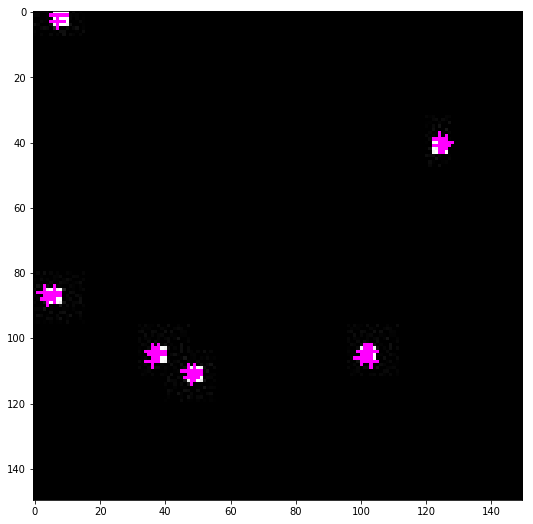

In [182]:
n = 66
S = np.load('./data/sensing_matrix.npy')
shape = (150,150)
L = 5
M = int(round(np.sqrt(2)*150))
pts = comp.decompress(y_[n].reshape(5,100),S,shape,L,M)
im = x[n].cpu().detach().numpy().squeeze()
for p in pts:
    im=comp.draw_plus(p,im)
plt.imshow(im)

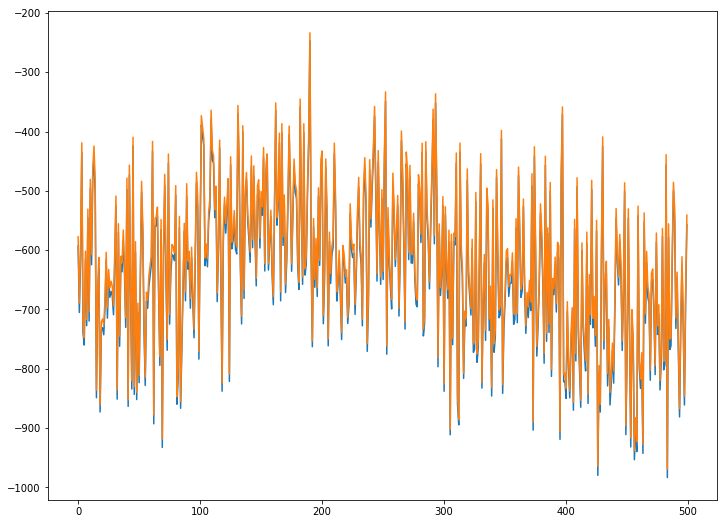

In [138]:
plt.plot(y[0])
plt.plot(y_[0])

In [189]:
# totally works on 1 sample. it will work on all of them. 

# train the network 

In [194]:
# initialize the model 
model = Net().to(device).train()

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,verbose=True)
train_losses = []
val_losses = []
min_val_loss = 999999.9 # for early stopping 

# set up the training loop and dataset iterator 
k = 100 #size of batch 
N = 1000 #number epochs
b = int(len(train_data)/k) #number of batches
train_loader = DataLoader(train_data , batch_size = k, shuffle = True) #batch data loader
test_loader = DataLoader(test_data, batch_size = k, shuffle = False)
val_data = next(iter(test_loader))

# train the network N epochs through the dataset 
for epoch in range(N): # epoch iterator 
    train_loss = 0 # mean loss per epoch 
    t0 = time.time() # to estimate claculation time per epoch 
    for i, (inputs, targets) in enumerate(train_loader): # batch iterator 
        inputs, targets = inputs.to(device), targets.to(device) # batch to gpu
        optimizer.zero_grad() # zero gradients
        outputs = model(inputs) # model prediction
        loss = criterion(outputs, targets)  # loss computation
        loss.backward() # backpropagation
        optimizer.step() # gradient descent 
        train_loss += loss.cpu().data.item()/k # average loss across a batch 
    train_loss /= i # average loss across an epoch 
    print('epoch {} completed in {} seconds with avg training loss {}'.format(epoch,
                                                                              round((time.time()-t0), 2),
                                                                              round(train_loss, 2)
                                                                             ))
    train_losses.append(train_loss)
    scheduler.step(train_loss) # possibly modify the learning rate if avg training loss has plateaued
    
    if epoch%5==0:  # early stopping 
        # calculate the avg validation loss per batch 
        inputs, targets = val_data
        inputs, targets = inputs.to(device), targets.to(device) # batch to gpu
        outputs = model(inputs) # model prediction
        loss = criterion(outputs, targets)
        val_loss = loss.cpu().data.item()/k # average loss over validation batch 
        val_losses.append(val_loss)
        if val_loss < min_val_loss:
            min_val_loss = val_loss 
            torch.save(model.state_dict(),'earlystop.pt') # save partially trained model 
            print('model saved (early stop). ', 'validation loss was ', min_val_loss)
        else:
            print('model not saved. validation loss was ', val_loss)

epoch 0 completed in 30.03 seconds with avg training loss 102.05
model saved (early stop).  validation loss was  146.87146484375
epoch 1 completed in 31.64 seconds with avg training loss 98.77
epoch 2 completed in 31.66 seconds with avg training loss 97.86
epoch 3 completed in 31.05 seconds with avg training loss 97.24
epoch 4 completed in 31.59 seconds with avg training loss 99.53
epoch 5 completed in 31.36 seconds with avg training loss 96.64
model not saved. validation loss was  158.0437109375
epoch 6 completed in 29.61 seconds with avg training loss 96.92
epoch 7 completed in 30.97 seconds with avg training loss 96.35
epoch 8 completed in 31.5 seconds with avg training loss 95.85
epoch 9 completed in 32.94 seconds with avg training loss 95.26
epoch 10 completed in 31.75 seconds with avg training loss 94.28
model saved (early stop).  validation loss was  133.54802734375
epoch 11 completed in 32.56 seconds with avg training loss 94.32
epoch 12 completed in 31.95 seconds with avg trai

Text(0,0.5,'loss')

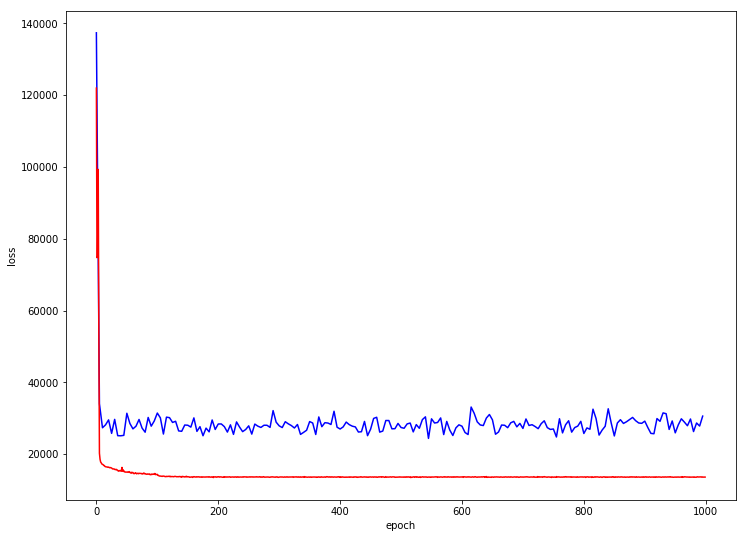

In [38]:
plt.plot(range(0,5*len(val_losses),5),val_losses,color='blue')
plt.plot(range(len(train_losses)),train_losses,color='red')
plt.xlabel('epoch')
plt.ylabel('loss')

# diagnose output by decompression / visualization 

In [ ]:
model.state_dict() = torch.load('trained.pt')
model.eval()

In [ ]:
test_loader = DataLoader(test_data , batch_size = k, shuffle = True) #batch data loader
for i,(x,y) in enumerate(test_loader):
    break
y_ = model(x.to(device)).cpu().detach().numpy()
y = y.numpy()

In [ ]:
for n in range(3):
    plt.plot(y[n],'x')
    plt.plot(y_[n],'o')
    plt.show()

In [ ]:
S = np.load('./data/sensing_matrix.npy')
shape = x[0].numpy().shape[1:]
_,M = shape
N = 100
L = 5

In [ ]:
Y = y_[0]
Y = Y.reshape(L,N)

In [ ]:
pts = comp.unproject(F,shape,5,M)

In [ ]:
im = x[0].numpy().squeeze()
for p in pts:
    im = comp.draw_plus(p,im)
plt.imshow(im,cmap='gray')

In [ ]:
mask = (pts.T[0]>0)&(pts.T[0]<150)&(pts.T[1]>0)&(pts.T[1]<150)
np.where(mask)